In [33]:
import os
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt

from tqdm import tqdm

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 1. Data preparation

In [27]:
def load_data(root_dir, val_size=0.2):
    X_b_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(root_dir+'/benign')) for f in fn if f.endswith(').png')])
    y_b_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(root_dir+'/benign')) for f in fn if f.endswith(')_mask.png')])
    X_m_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(root_dir+'/malognant')) for f in fn if f.endswith(').png')])
    y_m_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(root_dir+'/malognant')) for f in fn if f.endswith(')_mask.png')])
    X_n_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(root_dir+'/normal')) for f in fn if f.endswith(').png')])
    y_n_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(root_dir+'/normal')) for f in fn if f.endswith(')_mask.png')])
    
    b_pos = int(-len(X_b_paths)*val_size)
    m_pos = int(-len(X_m_paths)*val_size)
    n_pos = int(-len(X_n_paths)*val_size)
    
    X_train_paths = X_b_paths[:b_pos] + X_m_paths[:m_pos] + X_n_paths[:n_pos]
    y_train_paths = y_b_paths[:b_pos] + y_m_paths[:m_pos] + y_n_paths[:n_pos]    
    X_val_paths = X_b_paths[b_pos:] + X_m_paths[m_pos:] + X_n_paths[n_pos:]
    y_val_paths = y_b_paths[b_pos:] + y_m_paths[m_pos:] + y_n_paths[n_pos:]
    
    return X_train_paths, y_train_paths, X_val_paths, y_val_paths
    
root_dir = 'data/Dataset_BUSI_with_GT'
X_train_paths, y_train_paths, X_val_paths, y_val_paths = load_data(root_dir, val_size=0.2)

len(X_train_paths), len(X_val_paths)

(457, 113)

In [24]:
class BUSI_Dataset(Dataset):
    def __init__(self, X_paths, y_paths, transform=None):
        self.X_paths = X_paths
        self.y_paths = y_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.X_paths)
    
    def __getitem__(self, idx):
        image_path = self.X_paths[idx]
        mask_path = self.y_paths[idx]
        
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

In [25]:
image_size = 224
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

In [28]:
train_dataset = BUSI_Dataset(X_train_paths, y_train_paths, train_transforms)
val_dataset = BUSI_Dataset(X_val_paths, y_val_paths, val_transforms)

In [29]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [30]:
img, mask = next(iter(train_loader))

img.shape, mask.shape

(torch.Size([8, 1, 224, 224]), torch.Size([8, 1, 224, 224]))

# 2. Define model

In [31]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [35]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNet, self).__init__()

        # Define channels for different stages
        channels = [64, 128, 256, 512]
        
        # Define pooling layer
        self.maxpool = nn.MaxPool2d(2, 2)
    
        # Define encoder
        self.encoder = nn.ModuleList()
        for channel in channels:
            self.encoder.append(DoubleConv(in_channels, channel))
            in_channels = channel

        # Define bottleneck layer
        self.bottleneck = DoubleConv(channels[-1], channels[-1] * 2)
        
        # Define decoder
        self.decoder = nn.ModuleList()
        for channel in reversed(channels):
            self.decoder.append(nn.ConvTranspose2d(channel * 2, channel, 2, 2))
            self.decoder.append(DoubleConv(channel * 2, channel))

        # Define last layer
        self.last = nn.Conv2d(channels[0], out_channels, 1)

    def forward(self, x):
        # Define storage for connections
        skip_connections = []

        # Down stages
        for block in self.encoder:
            x = block(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        # Bottleneck passing
        x = self.bottleneck(x)

        # Reverse list for easily taking
        skip_connections = skip_connections[::-1]

        # Up stages
        for i in range (0, len(self.decoder), 2):
            # Conv Transpose
            x = self.decoder[i](x)

            # Passing main block
            skip_connection = skip_connections[i // 2]

            ## Resize if neccessary
            if x.shape != skip_connection.shape:
                skip_connection = TF.resize(skip_connection, x.shape[2:]) # Resize except batch and channel
            ## Apply skip connection
            x = torch.cat((skip_connection, x), dim=1) # Concat by channel

            ## Go through conv block
            x = self.decoder[i+1](x)

        # Passing last layer to get output that each channel stand for each instance
        return self.last(x)

In [36]:
unet = UNet(1, 2).to(device)
unet = nn.DataParallel(unet)

# 3. Define controller

In [ ]:
def save_model(model, file_path):
    file_path = file_path + '.pth'
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
    # Save
    torch.save(model.state_dict(), file_path)
    print(f"Model is saved to: {file_path}")

In [ ]:
lr = 0.003
WD = 0.001

criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = torch.optim.Adam(params = unet.parameters(), lr=lr, weight_decay=WD)

/tmp/ipykernel_23/709905294.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, save_path=None, epochs=10):
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0

        for images, masks in tqdm(train_loader, unit='batch', desc=f'Training [{epoch+1}/{epochs}]'):
            images, masks = images.to(device), masks.to(device)

            mask_logits = model(images) # (B, C, H, W)

            # Permute channel to last size
            mask_logits = mask_logits.permute(0, 2, 3, 1) # (B, H, W, C)
            
            # Loss
            loss = criterion(mask_logits.reshape(-1, 2), masks.view(-1))
            train_loss += loss.item()

            # Update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy over pixel
            mask_pred = torch.argmax(mask_logits, dim = -1)
            acc_per_batch = torch.eq(mask_pred, masks).sum().item()
            train_acc += (acc_per_batch / masks.numel())
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        
        print(f'---> Train loss: {avg_train_loss:.4f}')
        print(f'---> Train acc: {avg_train_acc:.4f}')

        train_losses.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)
        
        # Validate
        val_loss, val_acc = 0,0
        model.eval()
        with torch.inference_mode():
            for images, masks in tqdm(val_loader, unit='batch', desc=f'Validate [{epoch+1}/{epochs}]'):
                images, masks = images.to(device), masks.to(device)
                
                mask_logits = model(images)
                mask_logits = mask_logits.permute(0,2,3,1)
                loss = criterion(mask_logits.reshape(-1, 2), masks.view(-1))
                val_loss += loss.item()
                
                mask_pred = torch.argmax(mask_logits, dim = -1)
                acc_per_batch = torch.eq(mask_pred, masks).sum().item()
                val_acc += (acc_per_batch / masks.numel())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        
        print(f'---> Valid loss: {avg_val_loss:.4f}')
        print(f'---> Valid acc: {avg_val_acc:.4f}')
        
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)
        
        if save_path is not None:
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                save_model(model, save_path + f'_epoch{epoch+1}')
    return train_losses, val_losses, train_accuracy, val_accuracy

# 5. Train

In [ ]:
save_path = '/kaggle/working/models/unet'

In [ ]:
train_losses, val_losses, train_accuracy, val_accuracy = train_model(unet, train_loader, val_loader, criterion, optimizer, device, save_path, epochs=10)

2024-12-08 08:41:12,724 - Starting Epoch 1/50
Training [1/50]:   0%|          | 0/150 [00:00<?, ?batch/s]/tmp/ipykernel_23/3483330389.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training [1/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 08:43:55,377 - Epoch 1 - Train Loss: 1.3661, Train Accuracy: 0.5635


---> Train loss: 1.3661
---> Train acc: 0.5635


Validate [1/50]:   0%|          | 0/13 [00:00<?, ?batch/s]/tmp/ipykernel_23/3483330389.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validate [1/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 08:44:09,125 - Epoch 1 - Val Loss: 1.5233, Val Accuracy: 0.4686


---> Valid loss: 1.5233
---> Valid acc: 0.4686


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
2024-12-08 08:44:09,368 - Model saved at /kaggle/working/models/unet_epoch1.pth
2024-12-08 08:44:09,369 - Starting Epoch 2/50


Model is saved to: /kaggle/working/models/unet_epoch1.pth


Training [2/50]: 100%|██████████| 150/150 [02:45<00:00,  1.10s/batch]
2024-12-08 08:46:54,717 - Epoch 2 - Train Loss: 1.4368, Train Accuracy: 0.5123


---> Train loss: 1.4368
---> Train acc: 0.5123


Validate [2/50]: 100%|██████████| 13/13 [00:14<00:00,  1.10s/batch]
2024-12-08 08:47:09,019 - Epoch 2 - Val Loss: 1.6399, Val Accuracy: 0.4431
2024-12-08 08:47:09,020 - Starting Epoch 3/50


---> Valid loss: 1.6399
---> Valid acc: 0.4431


Training [3/50]: 100%|██████████| 150/150 [02:51<00:00,  1.14s/batch]
2024-12-08 08:50:00,492 - Epoch 3 - Train Loss: 1.3954, Train Accuracy: 0.5263


---> Train loss: 1.3954
---> Train acc: 0.5263


Validate [3/50]: 100%|██████████| 13/13 [00:14<00:00,  1.10s/batch]
2024-12-08 08:50:14,838 - Epoch 3 - Val Loss: 1.3394, Val Accuracy: 0.5341


---> Valid loss: 1.3394
---> Valid acc: 0.5341


2024-12-08 08:50:15,047 - Model saved at /kaggle/working/models/unet_epoch3.pth
2024-12-08 08:50:15,048 - Starting Epoch 4/50


Model is saved to: /kaggle/working/models/unet_epoch3.pth


Training [4/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 08:52:57,086 - Epoch 4 - Train Loss: 1.3622, Train Accuracy: 0.5356


---> Train loss: 1.3622
---> Train acc: 0.5356


Validate [4/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 08:53:10,744 - Epoch 4 - Val Loss: 1.2944, Val Accuracy: 0.5494


---> Valid loss: 1.2944
---> Valid acc: 0.5494
Model is saved to: /kaggle/working/models/unet_epoch4.pth


2024-12-08 08:53:10,946 - Model saved at /kaggle/working/models/unet_epoch4.pth
2024-12-08 08:53:10,947 - Starting Epoch 5/50
Training [5/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 08:55:51,538 - Epoch 5 - Train Loss: 1.3216, Train Accuracy: 0.5486


---> Train loss: 1.3216
---> Train acc: 0.5486


Validate [5/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 08:56:05,245 - Epoch 5 - Val Loss: 1.3697, Val Accuracy: 0.5267
2024-12-08 08:56:05,247 - Starting Epoch 6/50


---> Valid loss: 1.3697
---> Valid acc: 0.5267


Training [6/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 08:58:47,488 - Epoch 6 - Train Loss: 1.2922, Train Accuracy: 0.5599


---> Train loss: 1.2922
---> Train acc: 0.5599


Validate [6/50]: 100%|██████████| 13/13 [00:14<00:00,  1.08s/batch]
2024-12-08 08:59:01,560 - Epoch 6 - Val Loss: 1.4445, Val Accuracy: 0.4803
2024-12-08 08:59:01,562 - Starting Epoch 7/50


---> Valid loss: 1.4445
---> Valid acc: 0.4803


Training [7/50]: 100%|██████████| 150/150 [02:39<00:00,  1.06s/batch]
2024-12-08 09:01:40,703 - Epoch 7 - Train Loss: 1.3006, Train Accuracy: 0.5582


---> Train loss: 1.3006
---> Train acc: 0.5582


Validate [7/50]: 100%|██████████| 13/13 [00:13<00:00,  1.02s/batch]
2024-12-08 09:01:54,014 - Epoch 7 - Val Loss: 1.2442, Val Accuracy: 0.5527


---> Valid loss: 1.2442
---> Valid acc: 0.5527


2024-12-08 09:01:54,248 - Model saved at /kaggle/working/models/unet_epoch7.pth
2024-12-08 09:01:54,250 - Starting Epoch 8/50


Model is saved to: /kaggle/working/models/unet_epoch7.pth


Training [8/50]: 100%|██████████| 150/150 [02:45<00:00,  1.10s/batch]
2024-12-08 09:04:39,750 - Epoch 8 - Train Loss: 1.2714, Train Accuracy: 0.5576


---> Train loss: 1.2714
---> Train acc: 0.5576


Validate [8/50]: 100%|██████████| 13/13 [00:14<00:00,  1.10s/batch]
2024-12-08 09:04:54,023 - Epoch 8 - Val Loss: 1.3620, Val Accuracy: 0.5225
2024-12-08 09:04:54,025 - Starting Epoch 9/50


---> Valid loss: 1.3620
---> Valid acc: 0.5225


Training [9/50]: 100%|██████████| 150/150 [02:44<00:00,  1.09s/batch]
2024-12-08 09:07:38,082 - Epoch 9 - Train Loss: 1.2683, Train Accuracy: 0.5635


---> Train loss: 1.2683
---> Train acc: 0.5635


Validate [9/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 09:07:51,767 - Epoch 9 - Val Loss: 1.3258, Val Accuracy: 0.5348
2024-12-08 09:07:51,769 - Starting Epoch 10/50


---> Valid loss: 1.3258
---> Valid acc: 0.5348


Training [10/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 09:10:34,161 - Epoch 10 - Train Loss: 1.2443, Train Accuracy: 0.5690


---> Train loss: 1.2443
---> Train acc: 0.5690


Validate [10/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 09:10:48,007 - Epoch 10 - Val Loss: 1.3377, Val Accuracy: 0.5338
2024-12-08 09:10:48,009 - Starting Epoch 11/50


---> Valid loss: 1.3377
---> Valid acc: 0.5338


Training [11/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 09:13:28,116 - Epoch 11 - Train Loss: 1.2157, Train Accuracy: 0.5789


---> Train loss: 1.2157
---> Train acc: 0.5789


Validate [11/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 09:13:41,858 - Epoch 11 - Val Loss: 1.2448, Val Accuracy: 0.5537
2024-12-08 09:13:41,859 - Starting Epoch 12/50


---> Valid loss: 1.2448
---> Valid acc: 0.5537


Training [12/50]: 100%|██████████| 150/150 [02:44<00:00,  1.10s/batch]
2024-12-08 09:16:26,397 - Epoch 12 - Train Loss: 1.2121, Train Accuracy: 0.5797


---> Train loss: 1.2121
---> Train acc: 0.5797


Validate [12/50]: 100%|██████████| 13/13 [00:14<00:00,  1.09s/batch]
2024-12-08 09:16:40,588 - Epoch 12 - Val Loss: 1.2563, Val Accuracy: 0.5427
2024-12-08 09:16:40,589 - Starting Epoch 13/50


---> Valid loss: 1.2563
---> Valid acc: 0.5427


Training [13/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 09:19:21,927 - Epoch 13 - Train Loss: 1.2027, Train Accuracy: 0.5834


---> Train loss: 1.2027
---> Train acc: 0.5834


Validate [13/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 09:19:35,628 - Epoch 13 - Val Loss: 1.2521, Val Accuracy: 0.5514
2024-12-08 09:19:35,630 - Starting Epoch 14/50


---> Valid loss: 1.2521
---> Valid acc: 0.5514


Training [14/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 09:22:16,411 - Epoch 14 - Train Loss: 1.1932, Train Accuracy: 0.5860


---> Train loss: 1.1932
---> Train acc: 0.5860


Validate [14/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 09:22:30,097 - Epoch 14 - Val Loss: 1.2978, Val Accuracy: 0.5404
2024-12-08 09:22:30,098 - Starting Epoch 15/50


---> Valid loss: 1.2978
---> Valid acc: 0.5404


Training [15/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 09:25:10,514 - Epoch 15 - Train Loss: 1.2051, Train Accuracy: 0.5825


---> Train loss: 1.2051
---> Train acc: 0.5825


Validate [15/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 09:25:24,177 - Epoch 15 - Val Loss: 1.2572, Val Accuracy: 0.5639
2024-12-08 09:25:24,178 - Starting Epoch 16/50


---> Valid loss: 1.2572
---> Valid acc: 0.5639


Training [16/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 09:28:07,557 - Epoch 16 - Train Loss: 1.2166, Train Accuracy: 0.5811


---> Train loss: 1.2166
---> Train acc: 0.5811


Validate [16/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 09:28:21,102 - Epoch 16 - Val Loss: 1.3223, Val Accuracy: 0.5084
2024-12-08 09:28:21,104 - Starting Epoch 17/50


---> Valid loss: 1.3223
---> Valid acc: 0.5084


Training [17/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 09:31:03,625 - Epoch 17 - Train Loss: 1.2107, Train Accuracy: 0.5792


---> Train loss: 1.2107
---> Train acc: 0.5792


Validate [17/50]: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch]
2024-12-08 09:31:17,070 - Epoch 17 - Val Loss: 1.1762, Val Accuracy: 0.5761


---> Valid loss: 1.1762
---> Valid acc: 0.5761


2024-12-08 09:31:17,279 - Model saved at /kaggle/working/models/unet_epoch17.pth
2024-12-08 09:31:17,280 - Starting Epoch 18/50


Model is saved to: /kaggle/working/models/unet_epoch17.pth


Training [18/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 09:33:59,474 - Epoch 18 - Train Loss: 1.1742, Train Accuracy: 0.5908


---> Train loss: 1.1742
---> Train acc: 0.5908


Validate [18/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 09:34:13,086 - Epoch 18 - Val Loss: 1.2760, Val Accuracy: 0.5284
2024-12-08 09:34:13,088 - Starting Epoch 19/50


---> Valid loss: 1.2760
---> Valid acc: 0.5284


Training [19/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 09:36:55,109 - Epoch 19 - Train Loss: 1.1770, Train Accuracy: 0.5903


---> Train loss: 1.1770
---> Train acc: 0.5903


Validate [19/50]: 100%|██████████| 13/13 [00:14<00:00,  1.08s/batch]
2024-12-08 09:37:09,161 - Epoch 19 - Val Loss: 1.3842, Val Accuracy: 0.5229
2024-12-08 09:37:09,162 - Starting Epoch 20/50


---> Valid loss: 1.3842
---> Valid acc: 0.5229


Training [20/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 09:39:52,269 - Epoch 20 - Train Loss: 1.1655, Train Accuracy: 0.5954


---> Train loss: 1.1655
---> Train acc: 0.5954


Validate [20/50]: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch]
2024-12-08 09:40:05,742 - Epoch 20 - Val Loss: 1.1733, Val Accuracy: 0.5747


---> Valid loss: 1.1733
---> Valid acc: 0.5747
Model is saved to: /kaggle/working/models/unet_epoch20.pth


2024-12-08 09:40:05,943 - Model saved at /kaggle/working/models/unet_epoch20.pth
2024-12-08 09:40:05,945 - Starting Epoch 21/50
Training [21/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 09:42:47,664 - Epoch 21 - Train Loss: 1.1565, Train Accuracy: 0.5993


---> Train loss: 1.1565
---> Train acc: 0.5993


Validate [21/50]: 100%|██████████| 13/13 [00:14<00:00,  1.11s/batch]
2024-12-08 09:43:02,049 - Epoch 21 - Val Loss: 1.2066, Val Accuracy: 0.5671
2024-12-08 09:43:02,051 - Starting Epoch 22/50


---> Valid loss: 1.2066
---> Valid acc: 0.5671


Training [22/50]: 100%|██████████| 150/150 [02:42<00:00,  1.09s/batch]
2024-12-08 09:45:45,013 - Epoch 22 - Train Loss: 1.1523, Train Accuracy: 0.5972


---> Train loss: 1.1523
---> Train acc: 0.5972


Validate [22/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 09:45:58,832 - Epoch 22 - Val Loss: 1.2119, Val Accuracy: 0.5611
2024-12-08 09:45:58,833 - Starting Epoch 23/50


---> Valid loss: 1.2119
---> Valid acc: 0.5611


Training [23/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 09:48:39,454 - Epoch 23 - Train Loss: 1.1534, Train Accuracy: 0.5966


---> Train loss: 1.1534
---> Train acc: 0.5966


Validate [23/50]: 100%|██████████| 13/13 [00:13<00:00,  1.07s/batch]
2024-12-08 09:48:53,447 - Epoch 23 - Val Loss: 1.2386, Val Accuracy: 0.5545
2024-12-08 09:48:53,448 - Starting Epoch 24/50


---> Valid loss: 1.2386
---> Valid acc: 0.5545


Training [24/50]: 100%|██████████| 150/150 [02:44<00:00,  1.09s/batch]
2024-12-08 09:51:37,517 - Epoch 24 - Train Loss: 1.1304, Train Accuracy: 0.6063


---> Train loss: 1.1304
---> Train acc: 0.6063


Validate [24/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 09:51:51,183 - Epoch 24 - Val Loss: 1.1829, Val Accuracy: 0.5656
2024-12-08 09:51:51,185 - Starting Epoch 25/50


---> Valid loss: 1.1829
---> Valid acc: 0.5656


Training [25/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 09:54:34,232 - Epoch 25 - Train Loss: 1.1552, Train Accuracy: 0.5959


---> Train loss: 1.1552
---> Train acc: 0.5959


Validate [25/50]: 100%|██████████| 13/13 [00:13<00:00,  1.07s/batch]
2024-12-08 09:54:48,179 - Epoch 25 - Val Loss: 1.1751, Val Accuracy: 0.5771
2024-12-08 09:54:48,181 - Starting Epoch 26/50


---> Valid loss: 1.1751
---> Valid acc: 0.5771


Training [26/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 09:57:30,725 - Epoch 26 - Train Loss: 1.1398, Train Accuracy: 0.6024


---> Train loss: 1.1398
---> Train acc: 0.6024


Validate [26/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 09:57:44,324 - Epoch 26 - Val Loss: 1.1560, Val Accuracy: 0.5843


---> Valid loss: 1.1560
---> Valid acc: 0.5843
Model is saved to: /kaggle/working/models/unet_epoch26.pth


2024-12-08 09:57:44,526 - Model saved at /kaggle/working/models/unet_epoch26.pth
2024-12-08 09:57:44,527 - Starting Epoch 27/50
Training [27/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 10:00:26,627 - Epoch 27 - Train Loss: 1.1143, Train Accuracy: 0.6097


---> Train loss: 1.1143
---> Train acc: 0.6097


Validate [27/50]: 100%|██████████| 13/13 [00:14<00:00,  1.09s/batch]
2024-12-08 10:00:40,876 - Epoch 27 - Val Loss: 1.1556, Val Accuracy: 0.5782


---> Valid loss: 1.1556
---> Valid acc: 0.5782
Model is saved to: /kaggle/working/models/unet_epoch27.pth


2024-12-08 10:00:41,076 - Model saved at /kaggle/working/models/unet_epoch27.pth
2024-12-08 10:00:41,078 - Starting Epoch 28/50
Training [28/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 10:03:22,539 - Epoch 28 - Train Loss: 1.1355, Train Accuracy: 0.6030


---> Train loss: 1.1355
---> Train acc: 0.6030


Validate [28/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 10:03:36,129 - Epoch 28 - Val Loss: 1.2575, Val Accuracy: 0.5402
2024-12-08 10:03:36,130 - Starting Epoch 29/50


---> Valid loss: 1.2575
---> Valid acc: 0.5402


Training [29/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 10:06:18,042 - Epoch 29 - Train Loss: 1.1239, Train Accuracy: 0.6066


---> Train loss: 1.1239
---> Train acc: 0.6066


Validate [29/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 10:06:31,764 - Epoch 29 - Val Loss: 1.1939, Val Accuracy: 0.5611
2024-12-08 10:06:31,765 - Starting Epoch 30/50


---> Valid loss: 1.1939
---> Valid acc: 0.5611


Training [30/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 10:09:14,273 - Epoch 30 - Train Loss: 1.1230, Train Accuracy: 0.6073


---> Train loss: 1.1230
---> Train acc: 0.6073


Validate [30/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 10:09:27,769 - Epoch 30 - Val Loss: 1.2457, Val Accuracy: 0.5451
2024-12-08 10:09:27,771 - Starting Epoch 31/50


---> Valid loss: 1.2457
---> Valid acc: 0.5451


Training [31/50]: 100%|██████████| 150/150 [02:44<00:00,  1.10s/batch]
2024-12-08 10:12:12,550 - Epoch 31 - Train Loss: 1.1264, Train Accuracy: 0.6052


---> Train loss: 1.1264
---> Train acc: 0.6052


Validate [31/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 10:12:26,143 - Epoch 31 - Val Loss: 1.1961, Val Accuracy: 0.5724
2024-12-08 10:12:26,145 - Starting Epoch 32/50


---> Valid loss: 1.1961
---> Valid acc: 0.5724


Training [32/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 10:15:06,401 - Epoch 32 - Train Loss: 1.1082, Train Accuracy: 0.6099


---> Train loss: 1.1082
---> Train acc: 0.6099


Validate [32/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 10:15:20,035 - Epoch 32 - Val Loss: 1.2166, Val Accuracy: 0.5549
2024-12-08 10:15:20,036 - Starting Epoch 33/50


---> Valid loss: 1.2166
---> Valid acc: 0.5549


Training [33/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 10:18:01,625 - Epoch 33 - Train Loss: 1.1093, Train Accuracy: 0.6105


---> Train loss: 1.1093
---> Train acc: 0.6105


Validate [33/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 10:18:15,162 - Epoch 33 - Val Loss: 1.2939, Val Accuracy: 0.5248
2024-12-08 10:18:15,163 - Starting Epoch 34/50


---> Valid loss: 1.2939
---> Valid acc: 0.5248


Training [34/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 10:20:58,980 - Epoch 34 - Train Loss: 1.1450, Train Accuracy: 0.5997


---> Train loss: 1.1450
---> Train acc: 0.5997


Validate [34/50]: 100%|██████████| 13/13 [00:14<00:00,  1.09s/batch]
2024-12-08 10:21:13,105 - Epoch 34 - Val Loss: 1.1997, Val Accuracy: 0.5571
2024-12-08 10:21:13,106 - Starting Epoch 35/50


---> Valid loss: 1.1997
---> Valid acc: 0.5571


Training [35/50]: 100%|██████████| 150/150 [02:39<00:00,  1.06s/batch]
2024-12-08 10:23:52,830 - Epoch 35 - Train Loss: 1.1388, Train Accuracy: 0.6013


---> Train loss: 1.1388
---> Train acc: 0.6013


Validate [35/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 10:24:06,581 - Epoch 35 - Val Loss: 1.1964, Val Accuracy: 0.5638
2024-12-08 10:24:06,583 - Starting Epoch 36/50


---> Valid loss: 1.1964
---> Valid acc: 0.5638


Training [36/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 10:26:49,727 - Epoch 36 - Train Loss: 1.1151, Train Accuracy: 0.6074


---> Train loss: 1.1151
---> Train acc: 0.6074


Validate [36/50]: 100%|██████████| 13/13 [00:13<00:00,  1.08s/batch]
2024-12-08 10:27:03,730 - Epoch 36 - Val Loss: 1.1959, Val Accuracy: 0.5591
2024-12-08 10:27:03,731 - Starting Epoch 37/50


---> Valid loss: 1.1959
---> Valid acc: 0.5591


Training [37/50]: 100%|██████████| 150/150 [02:44<00:00,  1.10s/batch]
2024-12-08 10:29:48,299 - Epoch 37 - Train Loss: 1.1021, Train Accuracy: 0.6109


---> Train loss: 1.1021
---> Train acc: 0.6109


Validate [37/50]: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch]
2024-12-08 10:30:01,690 - Epoch 37 - Val Loss: 1.2234, Val Accuracy: 0.5557
2024-12-08 10:30:01,691 - Starting Epoch 38/50


---> Valid loss: 1.2234
---> Valid acc: 0.5557


Training [38/50]: 100%|██████████| 150/150 [02:41<00:00,  1.08s/batch]
2024-12-08 10:32:43,109 - Epoch 38 - Train Loss: 1.1076, Train Accuracy: 0.6106


---> Train loss: 1.1076
---> Train acc: 0.6106


Validate [38/50]: 100%|██████████| 13/13 [00:13<00:00,  1.07s/batch]
2024-12-08 10:32:57,005 - Epoch 38 - Val Loss: 1.1284, Val Accuracy: 0.5827


---> Valid loss: 1.1284
---> Valid acc: 0.5827


2024-12-08 10:32:57,239 - Model saved at /kaggle/working/models/unet_epoch38.pth
2024-12-08 10:32:57,240 - Starting Epoch 39/50


Model is saved to: /kaggle/working/models/unet_epoch38.pth


Training [39/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 10:35:39,696 - Epoch 39 - Train Loss: 1.1055, Train Accuracy: 0.6100


---> Train loss: 1.1055
---> Train acc: 0.6100


Validate [39/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 10:35:53,362 - Epoch 39 - Val Loss: 1.1176, Val Accuracy: 0.5874


---> Valid loss: 1.1176
---> Valid acc: 0.5874


2024-12-08 10:35:53,570 - Model saved at /kaggle/working/models/unet_epoch39.pth
2024-12-08 10:35:53,571 - Starting Epoch 40/50


Model is saved to: /kaggle/working/models/unet_epoch39.pth


Training [40/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 10:38:37,065 - Epoch 40 - Train Loss: 1.1022, Train Accuracy: 0.6115


---> Train loss: 1.1022
---> Train acc: 0.6115


Validate [40/50]: 100%|██████████| 13/13 [00:14<00:00,  1.09s/batch]
2024-12-08 10:38:51,259 - Epoch 40 - Val Loss: 1.1886, Val Accuracy: 0.5708
2024-12-08 10:38:51,260 - Starting Epoch 41/50


---> Valid loss: 1.1886
---> Valid acc: 0.5708


Training [41/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 10:41:34,513 - Epoch 41 - Train Loss: 1.0974, Train Accuracy: 0.6128


---> Train loss: 1.0974
---> Train acc: 0.6128


Validate [41/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 10:41:48,195 - Epoch 41 - Val Loss: 1.1515, Val Accuracy: 0.5794
2024-12-08 10:41:48,196 - Starting Epoch 42/50


---> Valid loss: 1.1515
---> Valid acc: 0.5794


Training [42/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 10:44:31,670 - Epoch 42 - Train Loss: 1.0865, Train Accuracy: 0.6187


---> Train loss: 1.0865
---> Train acc: 0.6187


Validate [42/50]: 100%|██████████| 13/13 [00:14<00:00,  1.08s/batch]
2024-12-08 10:44:45,722 - Epoch 42 - Val Loss: 1.1203, Val Accuracy: 0.5920
2024-12-08 10:44:45,723 - Starting Epoch 43/50


---> Valid loss: 1.1203
---> Valid acc: 0.5920


Training [43/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 10:47:26,663 - Epoch 43 - Train Loss: 1.0866, Train Accuracy: 0.6172


---> Train loss: 1.0866
---> Train acc: 0.6172


Validate [43/50]: 100%|██████████| 13/13 [00:13<00:00,  1.03s/batch]
2024-12-08 10:47:40,108 - Epoch 43 - Val Loss: 1.1601, Val Accuracy: 0.5755
2024-12-08 10:47:40,109 - Starting Epoch 44/50


---> Valid loss: 1.1601
---> Valid acc: 0.5755


Training [44/50]: 100%|██████████| 150/150 [02:43<00:00,  1.09s/batch]
2024-12-08 10:50:23,854 - Epoch 44 - Train Loss: 1.0840, Train Accuracy: 0.6182


---> Train loss: 1.0840
---> Train acc: 0.6182


Validate [44/50]: 100%|██████████| 13/13 [00:14<00:00,  1.10s/batch]
2024-12-08 10:50:38,124 - Epoch 44 - Val Loss: 1.1714, Val Accuracy: 0.5667
2024-12-08 10:50:38,125 - Starting Epoch 45/50


---> Valid loss: 1.1714
---> Valid acc: 0.5667


Training [45/50]: 100%|██████████| 150/150 [02:41<00:00,  1.07s/batch]
2024-12-08 10:53:19,376 - Epoch 45 - Train Loss: 1.0871, Train Accuracy: 0.6176


---> Train loss: 1.0871
---> Train acc: 0.6176


Validate [45/50]: 100%|██████████| 13/13 [00:13<00:00,  1.05s/batch]
2024-12-08 10:53:32,993 - Epoch 45 - Val Loss: 1.1852, Val Accuracy: 0.5677
2024-12-08 10:53:32,994 - Starting Epoch 46/50


---> Valid loss: 1.1852
---> Valid acc: 0.5677


Training [46/50]: 100%|██████████| 150/150 [02:41<00:00,  1.07s/batch]
2024-12-08 10:56:14,125 - Epoch 46 - Train Loss: 1.0761, Train Accuracy: 0.6212


---> Train loss: 1.0761
---> Train acc: 0.6212


Validate [46/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 10:56:27,869 - Epoch 46 - Val Loss: 1.2496, Val Accuracy: 0.5393
2024-12-08 10:56:27,870 - Starting Epoch 47/50


---> Valid loss: 1.2496
---> Valid acc: 0.5393


Training [47/50]: 100%|██████████| 150/150 [02:42<00:00,  1.09s/batch]
2024-12-08 10:59:10,739 - Epoch 47 - Train Loss: 1.0732, Train Accuracy: 0.6222


---> Train loss: 1.0732
---> Train acc: 0.6222


Validate [47/50]: 100%|██████████| 13/13 [00:13<00:00,  1.06s/batch]
2024-12-08 10:59:24,594 - Epoch 47 - Val Loss: 1.1228, Val Accuracy: 0.5832
2024-12-08 10:59:24,595 - Starting Epoch 48/50


---> Valid loss: 1.1228
---> Valid acc: 0.5832


Training [48/50]: 100%|██████████| 150/150 [02:42<00:00,  1.08s/batch]
2024-12-08 11:02:07,010 - Epoch 48 - Train Loss: 1.0825, Train Accuracy: 0.6196


---> Train loss: 1.0825
---> Train acc: 0.6196


Validate [48/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 11:02:20,612 - Epoch 48 - Val Loss: 1.1218, Val Accuracy: 0.5897
2024-12-08 11:02:20,613 - Starting Epoch 49/50


---> Valid loss: 1.1218
---> Valid acc: 0.5897


Training [49/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 11:05:01,073 - Epoch 49 - Train Loss: 1.0642, Train Accuracy: 0.6225


---> Train loss: 1.0642
---> Train acc: 0.6225


Validate [49/50]: 100%|██████████| 13/13 [00:13<00:00,  1.07s/batch]
2024-12-08 11:05:14,976 - Epoch 49 - Val Loss: 1.1276, Val Accuracy: 0.5905
2024-12-08 11:05:14,978 - Starting Epoch 50/50


---> Valid loss: 1.1276
---> Valid acc: 0.5905


Training [50/50]: 100%|██████████| 150/150 [02:40<00:00,  1.07s/batch]
2024-12-08 11:07:55,883 - Epoch 50 - Train Loss: 1.0778, Train Accuracy: 0.6196


---> Train loss: 1.0778
---> Train acc: 0.6196


Validate [50/50]: 100%|██████████| 13/13 [00:13<00:00,  1.04s/batch]
2024-12-08 11:08:09,466 - Epoch 50 - Val Loss: 1.1324, Val Accuracy: 0.5871


---> Valid loss: 1.1324
---> Valid acc: 0.5871


# 6. Visualize results

Text(0.5, 1.0, 'Train Accuracy')

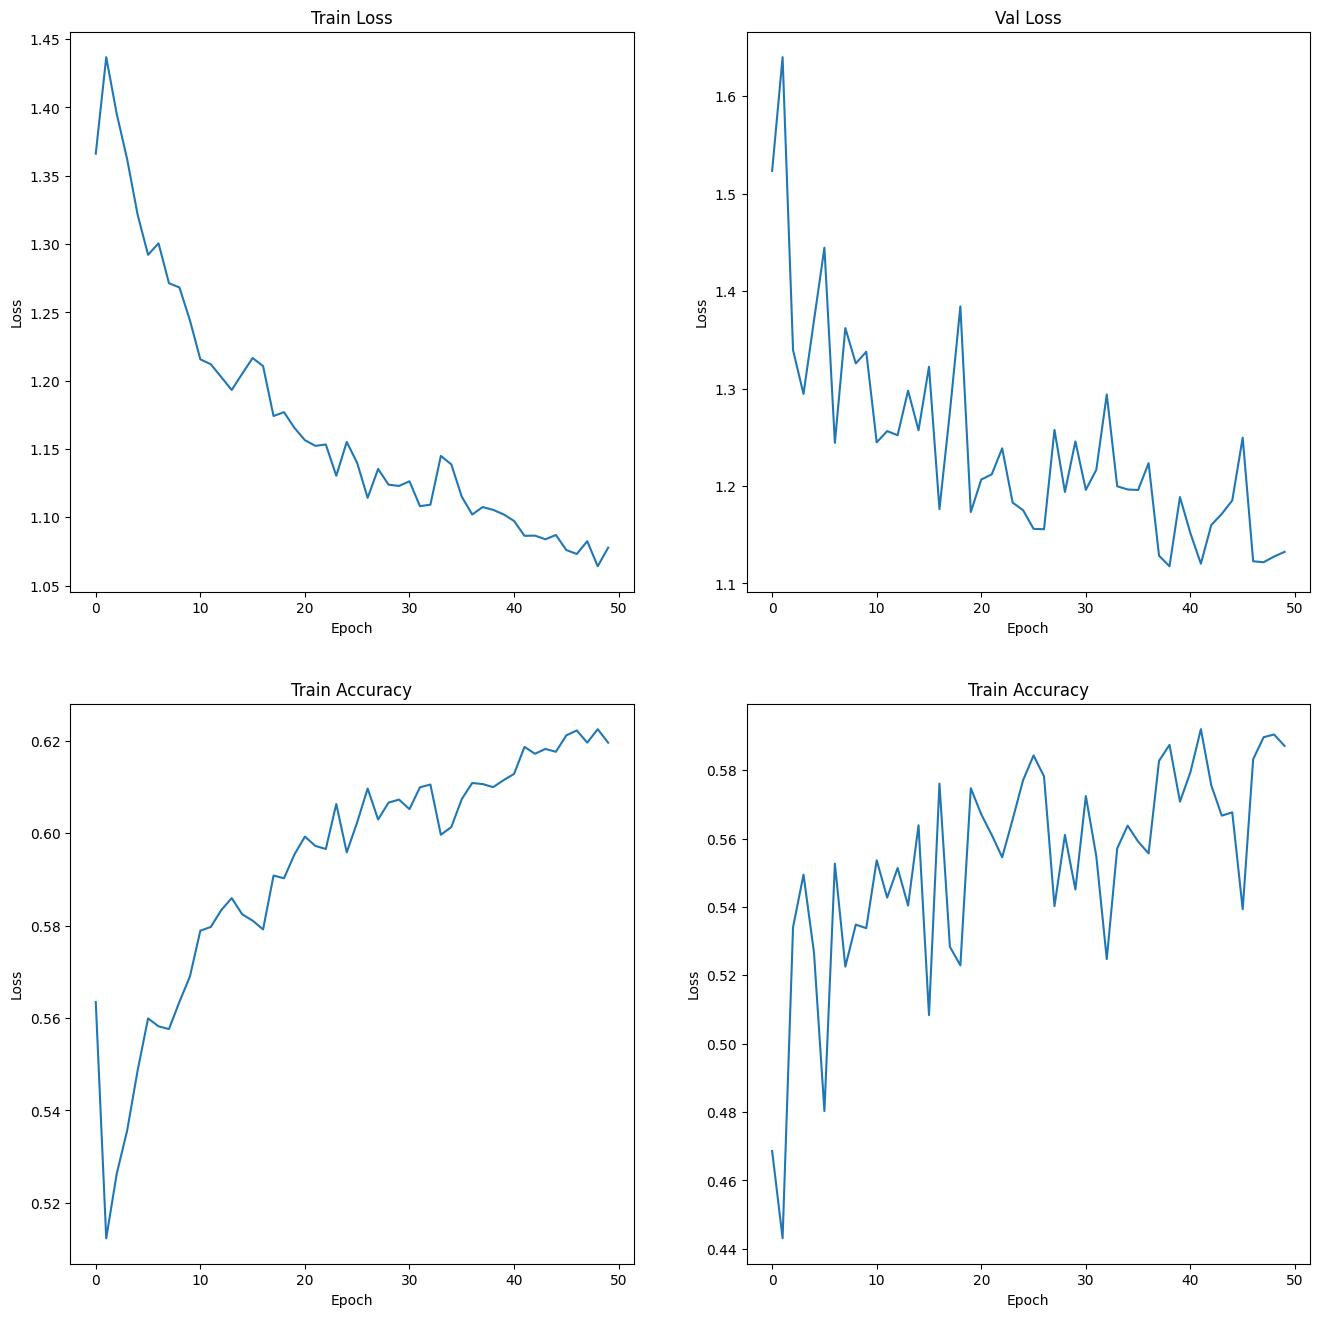

In [ ]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Val Loss")

plt.subplot(2, 2, 3)
plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Accuracy")

plt.subplot(2, 2, 4)
plt.plot(val_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Val Accuracy")

In [ ]:
def get_mask(model, image):
    """
        model: UNet model
        image: input image, size of (B, C, W, H)
    """
    # Compute logit
    model.eval()
    mask_logit = model(image)
    mask_logit = F.interpolate(mask_logit, size=(1024, 2048), mode='bilinear', align_corners=False)
    print(mask_logit.shape)
    mask_logit = mask_logit.permute(0, 2, 3, 1)
    mask_pred = torch.argmax(mask_logit, dim = -1) # Get label
    print(mask_pred.shape)
    mask_pred = mask_pred.squeeze() # Remove batch
    mask_pred = mask_pred.cpu().numpy()
    print(mask_pred.shape)
    
    # Color mapping
    rgb_mask = np.zeros((1024, 2048, 3), dtype=np.uint8)
    for class_id in range(color_map.shape[0]):
        rgb_mask[mask_pred == class_id] = color_map[class_id]

    return rgb_mask